# TimeSeries Clustering : Beauty
* 2018, 2019 각각 `scaling` 후 Clustering 

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np 
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt 

plt.style.use('seaborn')
plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)

import dataload

import requests
import datetime as datetime
from tqdm import tqdm, tqdm_notebook

from tslearn.clustering import TimeSeriesKMeans

In [2]:
buy_full = dataload.load_buy()
print(buy_full.shape)
buy_full.head()

(2056899, 6)


,date,sex,age,big_cat,sm_cat,qty
0,20180101,F,20,식품,가공란,37
1,20180101,F,30,식품,가공란,16
2,20180101,F,40,식품,가공란,9
3,20180101,F,50,식품,가공란,3
4,20180101,M,20,식품,가공란,13


In [5]:
product = pd.read_csv("ProductFiltering.csv", encoding='cp949')
buy_full = buy_full[buy_full.sm_cat.isin(list(product.sm_cat.unique()))]

print(buy_full.shape)
buy_full.head()

(1070931, 6)


,date,sex,age,big_cat,sm_cat,qty
7,20180101,F,20,냉난방가전,가열식 가습기,1
8,20180101,F,40,냉난방가전,가열식 가습기,3
9,20180101,M,20,냉난방가전,가열식 가습기,1
10,20180101,M,40,냉난방가전,가열식 가습기,2
19,20180101,F,20,식품,갈비/찜/바비큐용 돈육,7


In [6]:
tqdm.pandas()

buy_full['year'] = buy_full['date'].progress_apply(lambda x :str(x)[:4])
buy_2018 = buy_full[buy_full.year=='2018'][['date', 'sex', 'age', 'big_cat', 'sm_cat', 'qty']]
buy_2019 = buy_full[buy_full.year=='2019'][['date', 'sex', 'age', 'big_cat', 'sm_cat', 'qty']]
buy_2018['date'] = buy_2018['date'].progress_apply(lambda x : pd.to_datetime(str(x), format='%Y%m%d'))
buy_2019['date'] = buy_2019['date'].progress_apply(lambda x : pd.to_datetime(str(x), format='%Y%m%d'))

buy_2018.shape, buy_2019.shape

100%|██████████| 546880/546880 [00:59<00:00, 9232.69it/s]


((524051, 6), (546880, 6))

In [7]:
buy_2018.head()

,date,sex,age,big_cat,sm_cat,qty
7,2018-01-01,F,20,냉난방가전,가열식 가습기,1
8,2018-01-01,F,40,냉난방가전,가열식 가습기,3
9,2018-01-01,M,20,냉난방가전,가열식 가습기,1
10,2018-01-01,M,40,냉난방가전,가열식 가습기,2
19,2018-01-01,F,20,식품,갈비/찜/바비큐용 돈육,7


In [8]:
buy_2018 = buy_2018.groupby(['date', 'big_cat', 'sm_cat']).sum('qty').reset_index()[["date", "big_cat", "sm_cat", "qty"]]
buy_2019 = buy_2019.groupby(['date', 'big_cat', 'sm_cat']).sum('qty').reset_index()[["date", "big_cat", "sm_cat", "qty"]]

In [9]:
buy_2018["date"] = buy_2018["date"] + datetime.timedelta(days=-1)
buy_2018["date"] = buy_2018["date"].progress_apply(lambda x : x.replace(year=2018, month=12, day=31) if x==datetime.date(2017, 12, 31) else x)

100%|██████████| 68596/68596 [00:00<00:00, 255661.48it/s]


In [10]:
buy_2018.date.nunique()

365

In [11]:
buy_2018["date"] = buy_2018["date"].apply(lambda x : str(x)[5:])
buy_2019["date"] = buy_2019["date"].apply(lambda x : str(x)[5:])

In [12]:
# 뷰티 
df_beauty2018 = buy_2018[buy_2018.big_cat == '뷰티'].reset_index(drop=True).drop('big_cat', axis=1)
df_beauty2019 = buy_2019[buy_2019.big_cat == '뷰티'].reset_index(drop=True).drop('big_cat', axis=1)

In [13]:
df_beauty2018_ts = pd.pivot_table(df_beauty2018, index="sm_cat", columns="date", values="qty")
df_beauty2019_ts = pd.pivot_table(df_beauty2019, index="sm_cat", columns="date", values="qty")

print(df_beauty2018_ts.shape, df_beauty2019_ts.shape)

df_beauty2018_ts = df_beauty2018_ts.fillna(0)
df_beauty2019_ts = df_beauty2019_ts.fillna(0)

(67, 365) (67, 365)


In [14]:
df_beauty2018_ts.head()

date,01-01 00:00:00,01-02 00:00:00,01-03 00:00:00,01-04 00:00:00,01-05 00:00:00,01-06 00:00:00,01-07 00:00:00,01-08 00:00:00,01-09 00:00:00,01-10 00:00:00,01-11 00:00:00,01-12 00:00:00,01-13 00:00:00,01-14 00:00:00,01-15 00:00:00,01-16 00:00:00,01-17 00:00:00,01-18 00:00:00,01-19 00:00:00,01-20 00:00:00,01-21 00:00:00,01-22 00:00:00,01-23 00:00:00,01-24 00:00:00,01-25 00:00:00,01-26 00:00:00,01-27 00:00:00,01-28 00:00:00,01-29 00:00:00,01-30 00:00:00,01-31 00:00:00,02-01 00:00:00,02-02 00:00:00,02-03 00:00:00,02-04 00:00:00,02-05 00:00:00,02-06 00:00:00,02-07 00:00:00,02-08 00:00:00,02-09 00:00:00,02-10 00:00:00,02-11 00:00:00,02-12 00:00:00,02-13 00:00:00,02-14 00:00:00,02-15 00:00:00,02-16 00:00:00,02-17 00:00:00,02-18 00:00:00,02-19 00:00:00,02-20 00:00:00,02-21 00:00:00,02-22 00:00:00,02-23 00:00:00,02-24 00:00:00,02-25 00:00:00,02-26 00:00:00,02-27 00:00:00,02-28 00:00:00,03-01 00:00:00,03-02 00:00:00,03-03 00:00:00,03-04 00:00:00,03-05 00:00:00,03-06 00:00:00,03-07 00:00:00,03-08 00:00:00,03-09 00:00:00,03-10 00:00:00,03-11 00:00:00,03-12 00:00:00,03-13 00:00:00,03-14 00:00:00,03-15 00:00:00,03-16 00:00:00,03-17 00:00:00,03-18 00:00:00,03-19 00:00:00,03-20 00:00:00,03-21 00:00:00,03-22 00:00:00,03-23 00:00:00,03-24 00:00:00,03-25 00:00:00,03-26 00:00:00,03-27 00:00:00,03-28 00:00:00,03-29 00:00:00,03-30 00:00:00,03-31 00:00:00,04-01 00:00:00,04-02 00:00:00,04-03 00:00:00,04-04 00:00:00,04-05 00:00:00,04-06 00:00:00,04-07 00:00:00,04-08 00:00:00,04-09 00:00:00,04-10 00:00:00,04-11 00:00:00,04-12 00:00:00,04-13 00:00:00,04-14 00:00:00,04-15 00:00:00,04-16 00:00:00,04-17 00:00:00,04-18 00:00:00,04-19 00:00:00,04-20 00:00:00,04-21 00:00:00,04-22 00:00:00,04-23 00:00:00,04-24 00:00:00,04-25 00:00:00,04-26 00:00:00,04-27 00:00:00,04-28 00:00:00,04-29 00:00:00,04-30 00:00:00,05-01 00:00:00,05-02 00:00:00,05-03 00:00:00,05-04 00:00:00,05-05 00:00:00,05-06 00:00:00,05-07 00:00:00,05-08 00:00:00,05-09 00:00:00,05-10 00:00:00,05-11 00:00:00,05-12 00:00:00,05-13 00:00:00,05-14 00:00:00,05-15 00:00:00,05-16 00:00:00,05-17 00:00:00,05-18 00:00:00,05-19 00:00:00,05-20 00:00:00,05-21 00:00:00,05-22 00:00:00,05-23 00:00:00,05-24 00:00:00,05-25 00:00:00,05-26 00:00:00,05-27 00:00:00,05-28 00:00:00,05-29 00:00:00,05-30 00:00:00,05-31 00:00:00,06-01 00:00:00,06-02 00:00:00,06-03 00:00:00,06-04 00:00:00,06-05 00:00:00,06-06 00:00:00,06-07 00:00:00,06-08 00:00:00,06-09 00:00:00,06-10 00:00:00,06-11 00:00:00,06-12 00:00:00,06-13 00:00:00,06-14 00:00:00,06-15 00:00:00,06-16 00:00:00,06-17 00:00:00,06-18 00:00:00,06-19 00:00:00,06-20 00:00:00,06-21 00:00:00,06-22 00:00:00,06-23 00:00:00,06-24 00:00:00,06-25 00:00:00,06-26 00:00:00,06-27 00:00:00,06-28 00:00:00,06-29 00:00:00,06-30 00:00:00,07-01 00:00:00,07-02 00:00:00,07-03 00:00:00,07-04 00:00:00,07-05 00:00:00,07-06 00:00:00,07-07 00:00:00,07-08 00:00:00,07-09 00:00:00,07-10 00:00:00,07-11 00:00:00,07-12 00:00:00,07-13 00:00:00,07-14 00:00:00,07-15 00:00:00,07-16 00:00:00,07-17 00:00:00,07-18 00:00:00,07-19 00:00:00,07-20 00:00:00,07-21 00:00:00,07-22 00:00:00,07-23 00:00:00,07-24 00:00:00,07-25 00:00:00,07-26 00:00:00,07-27 00:00:00,07-28 00:00:00,07-29 00:00:00,07-30 00:00:00,07-31 00:00:00,08-01 00:00:00,08-02 00:00:00,08-03 00:00:00,08-04 00:00:00,08-05 00:00:00,08-06 00:00:00,08-07 00:00:00,08-08 00:00:00,08-09 00:00:00,08-10 00:00:00,08-11 00:00:00,08-12 00:00:00,08-13 00:00:00,08-14 00:00:00,08-15 00:00:00,08-16 00:00:00,08-17 00:00:00,08-18 00:00:00,08-19 00:00:00,08-20 00:00:00,08-21 00:00:00,08-22 00:00:00,08-23 00:00:00,08-24 00:00:00,08-25 00:00:00,08-26 00:00:00,08-27 00:00:00,08-28 00:00:00,08-29 00:00:00,08-30 00:00:00,08-31 00:00:00,09-01 00:00:00,09-02 00:00:00,09-03 00:00:00,09-04 00:00:00,09-05 00:00:00,09-06 00:00:00,09-07 00:00:00,09-08 00:00:00,09-09 00:00:00,09-10 00:00:00,09-11 00:00:00,09-12 00:00:00,09-13 00:00:00,09-14 00:00:00,09-15 00:00:00,09-16 00:00:00,09-17 00:00:00,09-18 00:00:00,09-19 00:00:00,09-20 00:00:00,09-21 00:00:00,09-22 00:00:00,09-23 00:00:00,09-24

## 1. 데이터 정규화 

In [15]:
def normalize_df(df) : 
    avg_lst = []; std_lst = []
    for idx, row in tqdm(df.iterrows()):
        avg_lst.append(row.mean())
        std_lst.append(row.std())

    df['avg'] = avg_lst
    df['std'] = std_lst


    for i in tqdm(range(len(df))):
        for j in range(365):
            df.iloc[i,j] = (df.iloc[i,j] - df.iloc[i,365])/df.iloc[i,366] 

    df = df.drop(['avg','std'], axis=1)
    return df 

In [16]:
df_beauty2018_ts = normalize_df(df_beauty2018_ts)
df_beauty2019_ts = normalize_df(df_beauty2019_ts)

67it [00:00, 4320.57it/s]
100%|██████████| 67/67 [00:03<00:00, 18.56it/s]
67it [00:00, 7489.43it/s]
100%|██████████| 67/67 [00:03<00:00, 18.95it/s]


In [17]:
beauty_ts = (df_beauty2018_ts + df_beauty2019_ts)/2
beauty_ts.shape

(67, 365)

In [18]:
beauty_ts.head()

date,01-01 00:00:00,01-02 00:00:00,01-03 00:00:00,01-04 00:00:00,01-05 00:00:00,01-06 00:00:00,01-07 00:00:00,01-08 00:00:00,01-09 00:00:00,01-10 00:00:00,01-11 00:00:00,01-12 00:00:00,01-13 00:00:00,01-14 00:00:00,01-15 00:00:00,01-16 00:00:00,01-17 00:00:00,01-18 00:00:00,01-19 00:00:00,01-20 00:00:00,01-21 00:00:00,01-22 00:00:00,01-23 00:00:00,01-24 00:00:00,01-25 00:00:00,01-26 00:00:00,01-27 00:00:00,01-28 00:00:00,01-29 00:00:00,01-30 00:00:00,01-31 00:00:00,02-01 00:00:00,02-02 00:00:00,02-03 00:00:00,02-04 00:00:00,02-05 00:00:00,02-06 00:00:00,02-07 00:00:00,02-08 00:00:00,02-09 00:00:00,02-10 00:00:00,02-11 00:00:00,02-12 00:00:00,02-13 00:00:00,02-14 00:00:00,02-15 00:00:00,02-16 00:00:00,02-17 00:00:00,02-18 00:00:00,02-19 00:00:00,02-20 00:00:00,02-21 00:00:00,02-22 00:00:00,02-23 00:00:00,02-24 00:00:00,02-25 00:00:00,02-26 00:00:00,02-27 00:00:00,02-28 00:00:00,03-01 00:00:00,03-02 00:00:00,03-03 00:00:00,03-04 00:00:00,03-05 00:00:00,03-06 00:00:00,03-07 00:00:00,03-08 00:00:00,03-09 00:00:00,03-10 00:00:00,03-11 00:00:00,03-12 00:00:00,03-13 00:00:00,03-14 00:00:00,03-15 00:00:00,03-16 00:00:00,03-17 00:00:00,03-18 00:00:00,03-19 00:00:00,03-20 00:00:00,03-21 00:00:00,03-22 00:00:00,03-23 00:00:00,03-24 00:00:00,03-25 00:00:00,03-26 00:00:00,03-27 00:00:00,03-28 00:00:00,03-29 00:00:00,03-30 00:00:00,03-31 00:00:00,04-01 00:00:00,04-02 00:00:00,04-03 00:00:00,04-04 00:00:00,04-05 00:00:00,04-06 00:00:00,04-07 00:00:00,04-08 00:00:00,04-09 00:00:00,04-10 00:00:00,04-11 00:00:00,04-12 00:00:00,04-13 00:00:00,04-14 00:00:00,04-15 00:00:00,04-16 00:00:00,04-17 00:00:00,04-18 00:00:00,04-19 00:00:00,04-20 00:00:00,04-21 00:00:00,04-22 00:00:00,04-23 00:00:00,04-24 00:00:00,04-25 00:00:00,04-26 00:00:00,04-27 00:00:00,04-28 00:00:00,04-29 00:00:00,04-30 00:00:00,05-01 00:00:00,05-02 00:00:00,05-03 00:00:00,05-04 00:00:00,05-05 00:00:00,05-06 00:00:00,05-07 00:00:00,05-08 00:00:00,05-09 00:00:00,05-10 00:00:00,05-11 00:00:00,05-12 00:00:00,05-13 00:00:00,05-14 00:00:00,05-15 00:00:00,05-16 00:00:00,05-17 00:00:00,05-18 00:00:00,05-19 00:00:00,05-20 00:00:00,05-21 00:00:00,05-22 00:00:00,05-23 00:00:00,05-24 00:00:00,05-25 00:00:00,05-26 00:00:00,05-27 00:00:00,05-28 00:00:00,05-29 00:00:00,05-30 00:00:00,05-31 00:00:00,06-01 00:00:00,06-02 00:00:00,06-03 00:00:00,06-04 00:00:00,06-05 00:00:00,06-06 00:00:00,06-07 00:00:00,06-08 00:00:00,06-09 00:00:00,06-10 00:00:00,06-11 00:00:00,06-12 00:00:00,06-13 00:00:00,06-14 00:00:00,06-15 00:00:00,06-16 00:00:00,06-17 00:00:00,06-18 00:00:00,06-19 00:00:00,06-20 00:00:00,06-21 00:00:00,06-22 00:00:00,06-23 00:00:00,06-24 00:00:00,06-25 00:00:00,06-26 00:00:00,06-27 00:00:00,06-28 00:00:00,06-29 00:00:00,06-30 00:00:00,07-01 00:00:00,07-02 00:00:00,07-03 00:00:00,07-04 00:00:00,07-05 00:00:00,07-06 00:00:00,07-07 00:00:00,07-08 00:00:00,07-09 00:00:00,07-10 00:00:00,07-11 00:00:00,07-12 00:00:00,07-13 00:00:00,07-14 00:00:00,07-15 00:00:00,07-16 00:00:00,07-17 00:00:00,07-18 00:00:00,07-19 00:00:00,07-20 00:00:00,07-21 00:00:00,07-22 00:00:00,07-23 00:00:00,07-24 00:00:00,07-25 00:00:00,07-26 00:00:00,07-27 00:00:00,07-28 00:00:00,07-29 00:00:00,07-30 00:00:00,07-31 00:00:00,08-01 00:00:00,08-02 00:00:00,08-03 00:00:00,08-04 00:00:00,08-05 00:00:00,08-06 00:00:00,08-07 00:00:00,08-08 00:00:00,08-09 00:00:00,08-10 00:00:00,08-11 00:00:00,08-12 00:00:00,08-13 00:00:00,08-14 00:00:00,08-15 00:00:00,08-16 00:00:00,08-17 00:00:00,08-18 00:00:00,08-19 00:00:00,08-20 00:00:00,08-21 00:00:00,08-22 00:00:00,08-23 00:00:00,08-24 00:00:00,08-25 00:00:00,08-26 00:00:00,08-27 00:00:00,08-28 00:00:00,08-29 00:00:00,08-30 00:00:00,08-31 00:00:00,09-01 00:00:00,09-02 00:00:00,09-03 00:00:00,09-04 00:00:00,09-05 00:00:00,09-06 00:00:00,09-07 00:00:00,09-08 00:00:00,09-09 00:00:00,09-10 00:00:00,09-11 00:00:00,09-12 00:00:00,09-13 00:00:00,09-14 00:00:00,09-15 00:00:00,09-16 00:00:00,09-17 00:00:00,09-18 00:00:00,09-19 00:00:00,09-20 00:00:00,09-21 00:00:00,09-22 00:00:00,09-23 00:00:00,09-24

## 2. 최적 k 찾기 

In [19]:
def visualize_elbowmethod(data, param_init='random', param_n_init=10, param_max_iter=300):
    distortions = []
    for i in tqdm(range(2, 7)): 
        ts_clustering = TimeSeriesKMeans(n_clusters=i, max_iter=param_max_iter, random_state=1234, metric = 'dtw')
        ts_clustering.fit(data)
        distortions.append(ts_clustering.inertia_)

    plt.plot(range(2, 7), distortions, marker='o')
    plt.xlabel('Number of Cluster')
    plt.ylabel('Distortion')
    plt.show()

100%|██████████| 5/5 [00:26<00:00,  5.24s/it]


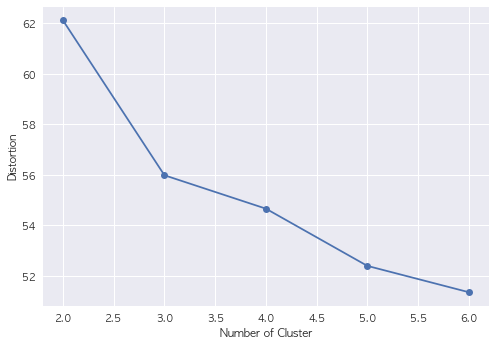

CPU times: user 1min 11s, sys: 7.55 s, total: 1min 18s
Wall time: 26.3 s


In [20]:
%time  visualize_elbowmethod(beauty_ts)

## 3. TimeSeries K Means

In [21]:
model1 = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=300, random_state=1234, n_jobs=-1)

for i in tqdm(range(len(beauty_ts))) : 
    model1.fit(beauty_ts)

100%|██████████| 67/67 [05:25<00:00,  4.85s/it]


In [22]:
df_beauty_result = pd.DataFrame({
    'sm_cat' : beauty_ts.index, 
    'cluster' : model1.labels_
})

In [23]:
df_beauty_result.cluster.value_counts()

0    29
2    19
1    19
Name: cluster, dtype: int64

In [24]:
# cluster 0 : 겨울에 조금 많아지는 ...
df_beauty_result[df_beauty_result.cluster==0]

,sm_cat,cluster
0,기능성 아이케어 화장품,0
1,기능성 영양보습 화장품,0
3,기초 화장용 로션,0
4,기초 화장용 미스트,0
5,기초 화장용 에센스,0
6,기초 화장용 오일/앰플,0
7,기초 화장용 크림,0
8,남성 로션,0
9,남성 메이크업,0
11,남성 세트,0


In [25]:
# cluster 1 : 여름   
df_beauty_result[df_beauty_result.cluster==1]

,sm_cat,cluster
10,남성 선케어,1
15,네일 메이크업 용품,1
17,네일아트,1
18,네일컬러,1
19,데오드란트,1
25,바디 클렌져,1
26,바디케어용 땀패드,1
29,바디케어용 제모제,1
34,베이스 메이크업용 쿠션팩트,1
35,뷰티 타투,1


In [26]:
# cluster 2 
df_beauty_result[df_beauty_result.cluster==2]

,sm_cat,cluster
2,기능성 화장품 세트,2
14,남성 크림,2
16,네일세트,2
27,바디케어용 때비누,2
28,바디케어용 슬리밍,2
31,베이스 메이크업용 CC크림,2
32,베이스 메이크업용 메이크업베이스,2
33,베이스 메이크업용 컨실러,2
36,뷰티용 뷰러,2
42,색조 메이크업 마스카라,2


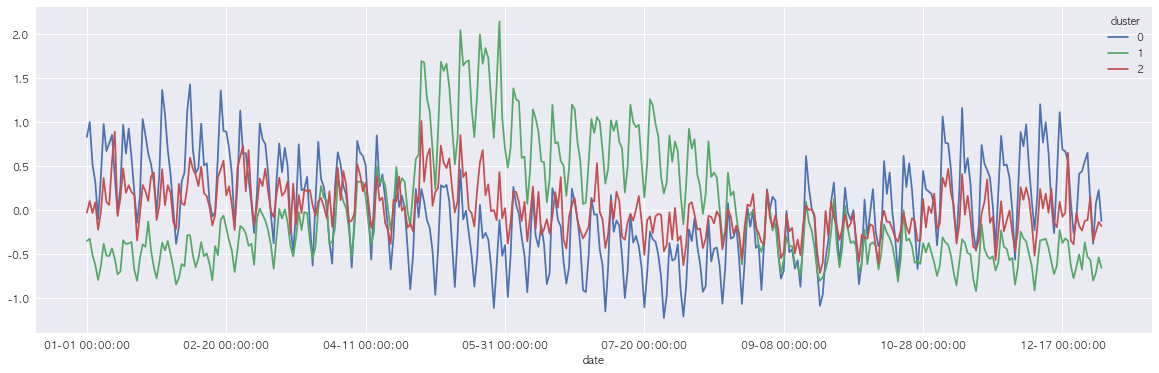

In [27]:
beauty_ts["cluster"] = model1.labels_

plt.rcParams["figure.figsize"]=(20,6)
beauty_ts.groupby(['cluster']).mean().T.plot()
plt.show()

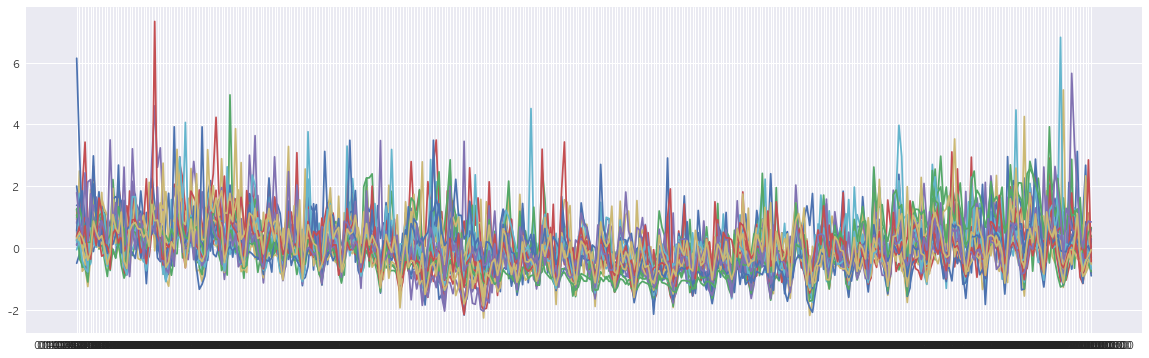

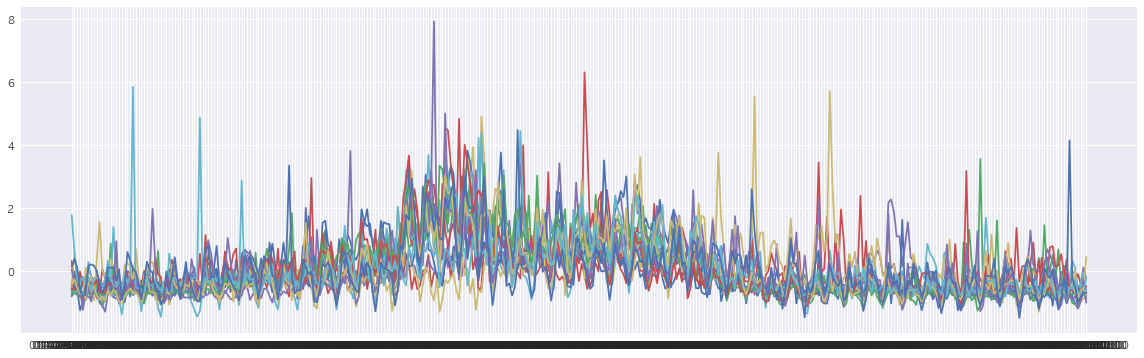

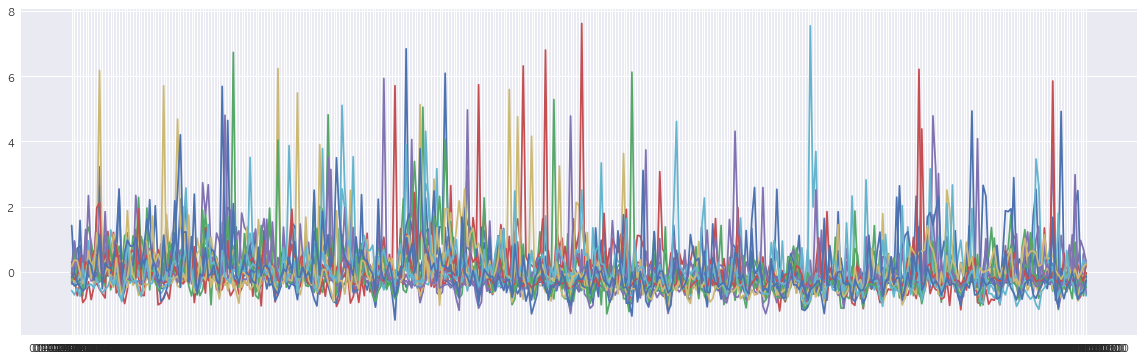

In [28]:
for i in range(3):
    clusters = beauty_ts[beauty_ts['cluster']==i]
    clusters.drop(['cluster'], axis=1, inplace=True)
    plt.figure(figsize=(20,6))
    plt.plot(clusters.T)
    plt.show

In [29]:
beauty_ts["cluster"] = model1.labels_
beauty_ts.to_csv("beauty_tsclustering_0613.csv", encoding='cp949')